## Process Optimization of Photonic Curing for Perovskites on Willow Glass

### Batch 1 Data Analysis + Batch 2 Experiment Suggestions

Zhe Liu, Ph.D. 
Northwestern Polytechnical University (NPU), Xi'an, P.R. China

In collaboration with Julia Hsu, Weijie Xu and Robert Piper at UT Dallas

V1.0 - 2021.09.20 

V2.0 - 2021.09.27

V3.0 - 2021.09.29

Install Anaconda and open this notebook in Jupyter

Requires Emukit package and its dependent packages (pyDOE, GPy, etc.)

    e.g. pip intall emukit (maybe, pip install pyDOE)

Experimental information:
Batch 0: LHS batch is 16 experimental conditions 
Batch 1: acquisition batch is 8 experimental conditions from BO and 8 from LHS in the unknown region
    - Upper bound for PC length was extended to 100 ms. 
Batch 2: acquisition batch is 16 experimental conditions from BO
    - Resolution (or step) of MAPbI3 concentration to 0.05 M
    - Resolution (or step) of CH2I2 concentration to 5 uL
    - Lower bound for MAPbI3 concentration was extended to 1.2

Samples: 4 pixel cells per substrate, and 2 duplicates per condition

Parameter resolution (Finest grid we are able to/are willing to tune). 
- Molar Concentration MAPbI3 - 0.05 M
- Addition of CH2I2 - 5 uL
- PC voltage - no limit (willing to tune 1 V)
- PC pulse-length - no limit (willing to tune 0.1 ms)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Find out the experimental noises in the data

In [2]:
df_data = pd.read_excel('Group1_run1&2_J-V_Data.xlsx').iloc[:108,:14]
df_data= df_data.sort_values(by=list(df_data.iloc[:,[0,-3]].columns))
std_dev_list = []
for c in range(int(max(df_data['Condition']+1))):
    eff_list_r1 = df_data[np.logical_and(df_data['Condition'] == c, df_data['Run'] == 1.0)].iloc[:,-3].values
    eff_list_r2 = df_data[np.logical_and(df_data['Condition'] == c, df_data['Run'] == 2.0)].iloc[:,-3].values
    eff_list = df_data[df_data['Condition'] == c].iloc[:,-4].values
    r = 0
    for eff_list_i in [eff_list_r1, eff_list_r2]:
        r = r +1 
        if len(eff_list_i)>1:
            std_dev = np.std(eff_list_i)
        elif len(eff_list_i)==1:
            std_dev = 0.0
        else:
            eff_list_i = np.append(eff_list_i, 0.0)
            std_dev = 0.0

        print('cond.',c, 'run', r, 'tot. num.', len(eff_list_i),' med. eff:', np.around(eff_list_i[-1],2), 'std_dev:', np.around(std_dev,2))


        std_dev_list.append([c, std_dev])

print('mean std_dev:', np.around(np.mean(np.array(std_dev_list)[np.array(std_dev_list)[:,-1]!=0.0][:,-1]),2))

# #find Q1, Q3, and interquartile range for each column
# Q1 = data.quantile(q=.25)
# Q3 = data.quantile(q=.75)
# IQR = data.apply(stats.iqr)

# #only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
# data_clean = data[~((data < (Q1-1.5*IQR)) | (data > (Q3+1.5*IQR))).any(axis=1)]


cond. 0 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 0 run 2 tot. num. 6  med. eff: 3.51 std_dev: 0.81
cond. 1 run 1 tot. num. 4  med. eff: 8.67 std_dev: 1.08
cond. 1 run 2 tot. num. 8  med. eff: 10.49 std_dev: 0.43
cond. 2 run 1 tot. num. 2  med. eff: 8.42 std_dev: 0.21
cond. 2 run 2 tot. num. 6  med. eff: 11.23 std_dev: 0.51
cond. 3 run 1 tot. num. 4  med. eff: 1.99 std_dev: 0.11
cond. 3 run 2 tot. num. 6  med. eff: 9.82 std_dev: 0.36
cond. 4 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 4 run 2 tot. num. 2  med. eff: 6.47 std_dev: 0.0
cond. 5 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 5 run 2 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 6 run 1 tot. num. 4  med. eff: 1.83 std_dev: 0.38
cond. 6 run 2 tot. num. 8  med. eff: 9.81 std_dev: 0.23
cond. 7 run 1 tot. num. 2  med. eff: 6.14 std_dev: 0.36
cond. 7 run 2 tot. num. 4  med. eff: 9.27 std_dev: 0.72
cond. 8 run 1 tot. num. 1  med. eff: 0.0 std_dev: 0.0
cond. 8 run 2 tot. num. 12  med. eff: 3.31 std_dev: 0.5
c

### Preprocessing the data for the regression model

In [3]:
df_data = pd.read_excel('Group0_run1&2_J-V_Data_BM.xlsx')
#df_data = df_data[np.logical_or(df_data['Scan Direction'] == 0, df_data['Scan Direction'] == 'F')]
df_data = df_data.sort_values(by=list(df_data.iloc[:,[0,11]].columns)).drop_duplicates('Condition', 
                                                                                        keep = 'last', 
                                                                                        ignore_index = True)
df_batch0 = df_data.iloc[:108,:14]

df_data = pd.read_excel('Group1_run1&2_J-V_Data.xlsx')
df_data['Condition'] = df_data['Condition']+16
#df_data = df_data[np.logical_or(df_data['Scan Direction'] == 0, df_data['Scan Direction'] == 'F')]
df_data = df_data.sort_values(by=list(df_data.iloc[:,[0,11]].columns)).drop_duplicates('Condition', 
                                                                                        keep = 'last', 
                                                                                        ignore_index = True)
df_batch1 = df_data.iloc[:108,:14]

df_data = pd.concat([df_batch0, df_batch1], ignore_index = True)
df_data

,Condition,MAPbI Conc [M],CH2I2 Conc [uL],Final Conc [M],PC voltage [V],PC length [ms],Sample,Diode,Voc [V],Jsc [mA/cm2],FF,PCE [%],Scan Direction,Run
0,0,1.6,150,1.319626,433,18.3,0,1.0,0.000,0.00,0.000,0.00,F,1.0
1,1,1.5,50,1.400794,222,17.1,1,2.0,0.907,2.15,0.520,1.02,R,1.0
2,2,1.5,100,1.313896,373,6.3,2,2.0,0.768,16.03,0.622,7.66,F,1.0
3,3,1.3,100,1.138710,252,11.1,3,4.0,0.712,2.69,0.456,0.87,F,1.0
4,4,1.6,100,1.401489,237,9.9,4,4.0,0.859,1.59,0.507,0.69,F,1.0
5,5,1.5,50,1.400794,358,12.3,5,3.0,0.476,17.20,0.413,3.38,F,2.0
6,6,1.4,0,1.400000,312,15.9,6,2.0,0.845,13.63,0.536,6.17,R,1.0
7,7,1.5,250,1.107741,328,19.5,7,1.0,0.991,16.59,0.656,10.78,F,2.0
8,8,1.6,200,1.246799,297,2.7,8,3.0,0.928,6.82,0.595,3.77,F,2.0
9,9,1.4,200,1.090949,267,7.5,9,6.0,0.935,4.08,0.498,1.90,F,1.0


In [4]:
df = df_data.iloc[:32,[1,2,4,5,8,9,10,11]]
df.columns = ['MAPbI Conc [M]', "CH₂I₂ Conc [μL]", "PC voltage [V]", 
              'PC length [ms]', 'Voc [V]', 'Jsc [mA/cm²]','FF [%]','PCE [%]']
df[df['PCE [%]']==0] = 0.1

df

,MAPbI Conc [M],CH₂I₂ Conc [μL],PC voltage [V],PC length [ms],Voc [V],Jsc [mA/cm²],FF [%],PCE [%]
0,0.1,0.1,0.1,0.1,0.100,0.10,0.100,0.10
1,1.5,50.0,222.0,17.1,0.907,2.15,0.520,1.02
2,1.5,100.0,373.0,6.3,0.768,16.03,0.622,7.66
3,1.3,100.0,252.0,11.1,0.712,2.69,0.456,0.87
4,1.6,100.0,237.0,9.9,0.859,1.59,0.507,0.69
5,1.5,50.0,358.0,12.3,0.476,17.20,0.413,3.38
6,1.4,0.0,312.0,15.9,0.845,13.63,0.536,6.17
7,1.5,250.0,328.0,19.5,0.991,16.59,0.656,10.78
8,1.6,200.0,297.0,2.7,0.928,6.82,0.595,3.77
9,1.4,200.0,267.0,7.5,0.935,4.08,0.498,1.90


### Define the parameter space

In [5]:
import emukit
import GPy
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

In [16]:
MAPbI_conc_min, MAPbI_conc_max, MAPbI_conc_step = [1.2, 1.6, 0.05]  # Unit: V 
### Give step a scaling factor of 0.1 to avoid numercial errors such as 1.7000002
MAPbI_conc_var = np.arange(MAPbI_conc_min, MAPbI_conc_max+MAPbI_conc_step*0.1, MAPbI_conc_step)
MAPbI_conc_num = len(MAPbI_conc_var)

CH2I2_conc_min, CH2I2_conc_max, CH2I2_conc_step = [0, 250, 5] ## Unit: μL
CH2I2_conc_var = np.arange(CH2I2_conc_min, CH2I2_conc_max+CH2I2_conc_step*0.1, CH2I2_conc_step)
CH2I2_conc_num = len(CH2I2_conc_var)

PC_volt_min, PC_volt_max, PC_volt_step = [200, 440, 1] ## Unit: V
PC_volt_var = np.arange(PC_volt_min, PC_volt_max+PC_volt_step*0.1, PC_volt_step) 
PC_volt_num = len(PC_volt_var)

PC_len_min, PC_len_max, PC_len_step = [1, 100, 0.1]  ## Unit: ms
PC_len_var = np.arange(PC_len_min, PC_len_max+PC_len_step*0.1, PC_len_step)
PC_len_num = len(PC_len_var)

var_array = [MAPbI_conc_var,
             CH2I2_conc_var, 
             PC_volt_var, 
             PC_len_var]

x_labels =  ["MAPbI Conc [M]",
             "CH₂I₂ Conc [μL]",
             "PC voltage [V]", 
             "PC length [ms]"]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [17]:
parameter_space = ParameterSpace([ContinuousParameter('MAPbI_conc', 0-1/(MAPbI_conc_num-1)/2, 1+1/(MAPbI_conc_num-1)/2),
                                  ContinuousParameter('CH2I2_conc', 0-1/(CH2I2_conc_num-1)/2, 1+1/(CH2I2_conc_num-1)/2),
                                  ContinuousParameter('PC_volt', 0-1/(PC_volt_num-1)/2, 1+1/(PC_volt_num-1)/2),
                                  ContinuousParameter('PC_len', 0-1/(PC_len_num-1)/2, 1+1/(PC_len_num-1)/2),
                                  ])


### Build a GP regression model 

In [18]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

x_exp = x_normalizer(df.iloc[:,0:4].values)
y_exp = np.transpose([df.iloc[:,-1].values])
X, Y = [x_exp, y_exp]

input_dim = len(X[0])
ker = GPy.kern.Matern52(input_dim = input_dim, ARD =True)#
ker.lengthscale.constrain_bounded(1e-1, 1)
ker.variance.constrain_bounded(1e-1, 1000.0)
model_gpy = GPRegression(X , -Y, ker)#Emukit is a minimization tool; need to make Y negative
model_gpy.Gaussian_noise.variance = 0.5**2
model_gpy.Gaussian_noise.variance.fix()
model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)
objective_model = GPyModelWrapper(model_gpy)
print(objective_model.model.kern.lengthscale)
print(objective_model.model.kern.variance)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                       0.64247133  |    0.1,1.0    |        
  [1]    |                       0.69957635  |    0.1,1.0    |        
  [2]    |                       0.17520767  |    0.1,1.0    |        
  [3]    |                       0.21089939  |    0.1,1.0    |        
  index  |  GP_regression.Mat52.variance  |  constraints  |  priors
  [0]    |                   31.08329676  |  0.1,1000.0   |        


MAE: 0.08   RMSE: 0.12   spearman: 0.997   R² score: 0.999


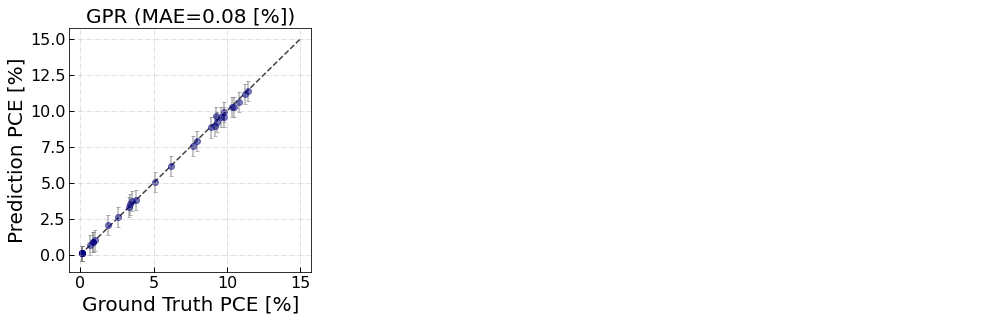

In [19]:
f_obj =  objective_model.model.predict
y_pred, y_uncer = f_obj(X)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 20
lims1 = (0, 15)
axes[0].scatter(Y[:,-1], y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(Y[:,-1], y_pred, yerr = y_uncer, ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
rmse_value = np.sqrt(mean_squared_error(Y[:,-1], y_pred))
mae_value = mean_absolute_error(Y[:,-1], y_pred)
spearman_value = spearmanr(Y[:,-1], y_pred)[0]
rsquared_value = r2_score(Y[:,-1], y_pred)

print('MAE:',np.round(mae_value,2), ' ',
      'RMSE:', np.round(rmse_value,2), ' ',
      'spearman:', np.round(spearman_value,3), ' ',
      'R² score:', np.round(rsquared_value,3))

title = 'GPR' + " (MAE=%.2f" % mae_value+' [%])'
axes[0].set_xlabel('Ground Truth PCE [%]', fontsize = fs)
axes[0].set_ylabel('Prediction PCE [%]', fontsize = fs)
axes[0].set_title(title, fontsize = fs)
        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

axes[1].axis("off")
axes[2].axis("off")

plt.show()



### Run BO to get  suggestions of new experimental conditons

In [20]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

np.random.seed(1000)#to make sure the random results is reproducible 
bs = 21

# ## Expeceted Improvement (EI)
## acquisition = ExpectedImprovement(objective_model, jitter=.1)
# ## Uppper Confidence Bound (UCB)
acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)
# ## Maximum Value Entropy Search (MES)
# acquisition = MaxValueEntropySearch(objective_model, parameter_space, grid_size = 10000*4)

# Make loop and collect points
bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)
                                   #batchsize may need to be >bs due to duplication

print('total condition no.:', len(X))
print('total device no.:', len(bayesopt.loop_state.Y))
print('maximum Y (PCE [%]): ', -np.min(np.transpose(np.round(bayesopt.loop_state.Y, 2))))

X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
f_acq = bayesopt.candidate_point_calculator.acquisition.acquisition.evaluate

df_Xnew = pd.DataFrame(get_closest_array(x_denormalizer(X_new)), columns = x_labels)
df_all = pd.concat([df.iloc[:,0:4], df_Xnew])
df_all_ = df_all.drop_duplicates()
df_Xnew = df_all_.iloc[len(df):len(df)+bs]
df_Xnew = df_Xnew.sort_values(by=list(df.columns[0:4]), ignore_index = True)
df_Xnew.index = np.arange(len(df_Xnew))+len(df)
print('New X:',len(df_Xnew))
df_Xnew


total condition no.: 32
total device no.: 32
maximum Y (PCE [%]):  11.42
New X: 16


,MAPbI Conc [M],CH₂I₂ Conc [μL],PC voltage [V],PC length [ms]
32,1.25,90.0,310.0,21.5
33,1.25,100.0,305.0,20.4
34,1.25,110.0,306.0,21.2
35,1.25,120.0,303.0,20.3
36,1.25,140.0,301.0,19.7
37,1.25,140.0,302.0,20.6
38,1.25,160.0,300.0,19.7
39,1.30,110.0,302.0,19.5
40,1.30,120.0,300.0,18.6
41,1.30,130.0,299.0,17.8


### Quick histogram visualization of the newly suggested process conditions

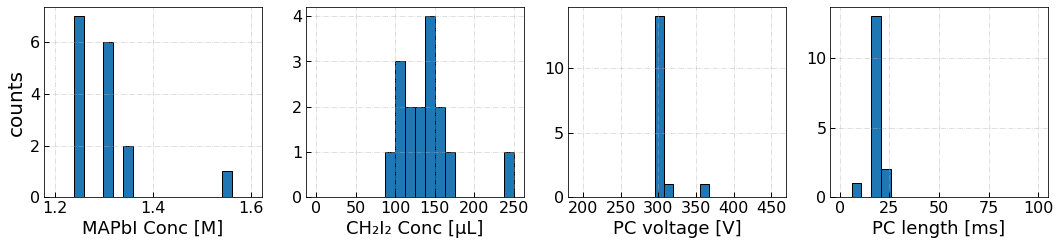

In [21]:
df_x = df_Xnew
df_cols = df.columns
n_col = 4 # num of columns per row in the figure
fs = 20
for n in np.arange(0, 4, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(18, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df_x.iloc[:,n], bins= 20, range = (min(var_array[n])- 0.05*abs(var_array[n][1]-var_array[n][0]),
                                                            max(var_array[n])+0.05*abs(var_array[n][1]-var_array[n][0])), 
                         edgecolor='black') ####
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
            #axes[i].set_xlim(min(var_array[n])*0.8,max(var_array[n])*1.05)
            if i==1:#MAPbI
                axes[i].set_xticks([0, 50, 100, 150, 200, 250])
            
            if i==2:#PC voltage
                axes[i].set_xticks([200, 250, 300, 350, 400, 450])
                axes[i].set_xlim(180,470)
                
            if i==3:#PC length
                axes[i].set_xticks([0, 25, 50, 75, 100])
                axes[i].set_xlim(-5,105)


        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = fs)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

### Visualisation of Efficiency vs ML conditions, and Acquisition

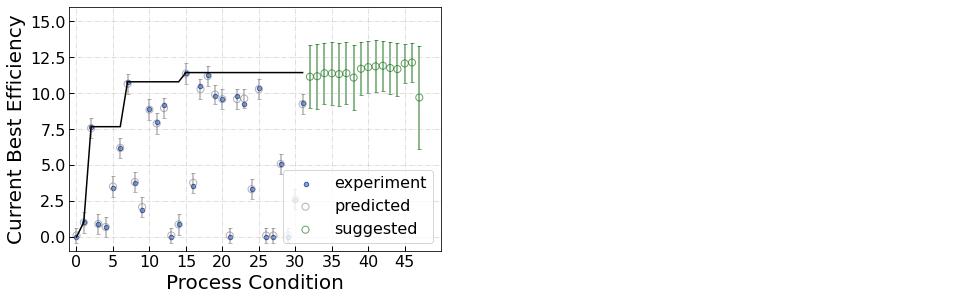

In [22]:
#f_obj =  objective_model.model.predict       
device_eff = df_data.sort_values('Condition').iloc[:,[0,-3]].values
fig, axes = plt.subplots(1, 2, figsize=(16, 4.5), sharey = False)
fs = 20
exp_cond = np.transpose(device_eff)[0]
exp_eff = np.transpose(device_eff)[1]

axes[0].scatter(exp_cond, exp_eff, #facecolor = 'none',
            edgecolor = 'navy', s = 20, alpha = 0.6, label = 'experiment')

axes[0].plot(np.transpose(exp_cond), np.maximum.accumulate(np.transpose(exp_eff)), 
         marker = 'o', ms = 0, c = 'black')

axes[0].scatter(np.arange(len(X)), y_pred,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'gray', label = 'predicted')
axes[0].errorbar(np.arange(len(X)), y_pred, yerr = y_uncer,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'gray', zorder = 0)


y_pred_new, y_uncer_new = f_obj(x_normalizer(df_Xnew.values))
y_pred_new = -y_pred_new[:,-1]
y_uncer_new = np.sqrt(y_uncer_new[:,-1])

axes[0].scatter(np.arange(len(df_Xnew))+len(X), y_pred_new,
                s = 50, facecolors='none', alpha = 0.6, edgecolor = 'darkgreen', label = 'suggested')
axes[0].errorbar(np.arange(len(df_Xnew))+len(X), y_pred_new, yerr = y_uncer_new,  
                 ms = 0, ls = '', capsize = 2, alpha = 0.6, 
                 color = 'darkgreen', zorder = 0)


axes[0].set_ylabel('Current Best Efficiency', fontsize = 20)
axes[0].set_xlabel('Process Condition', fontsize = 20)

axes[0].set_ylim(-1, 16)
axes[0].set_xlim(-1, 50)
axes[0].set_xticks(np.arange(0,50,5))
axes[0].legend(fontsize = fs*0.8)

axes[1].axis("off")
for ax in axes:
    ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    ax.grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)

plt.show()

### Partial Dependence Plot 
#####  Two-varible contour map (with randomly sampling in the other two variables)

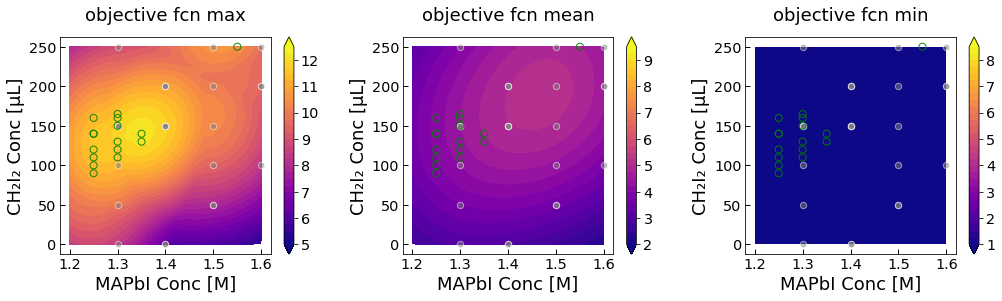

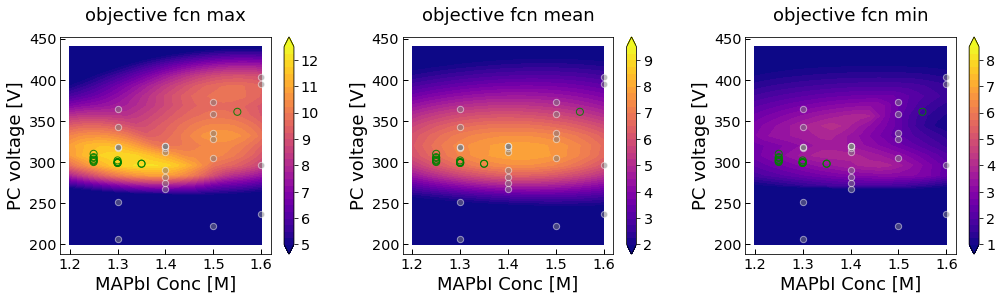

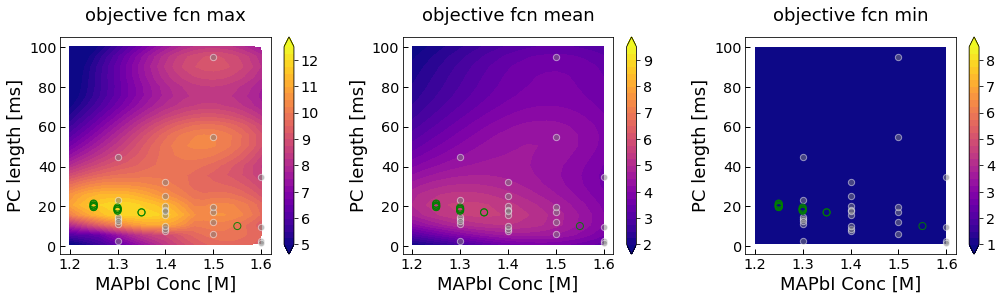

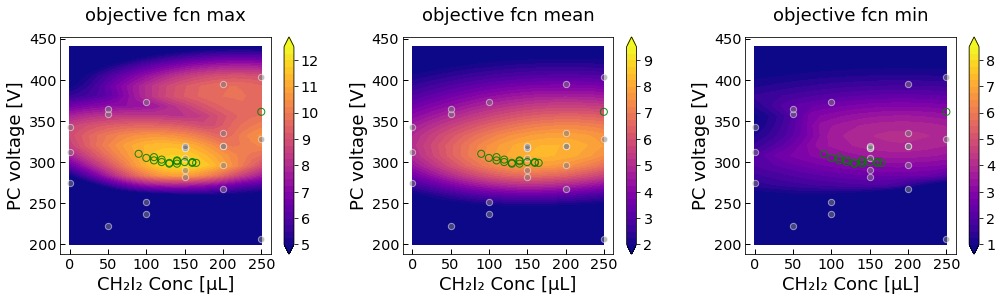

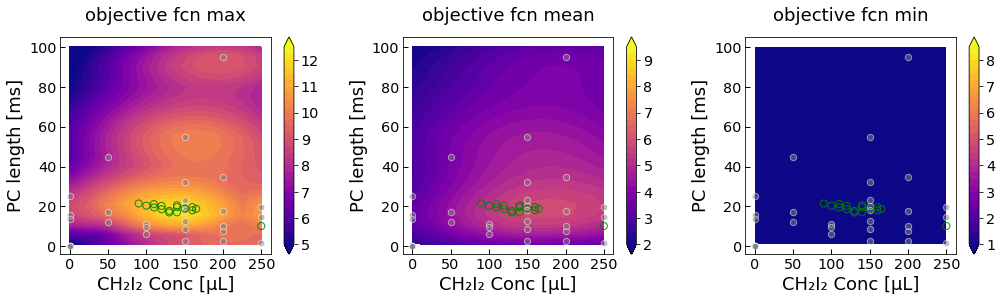

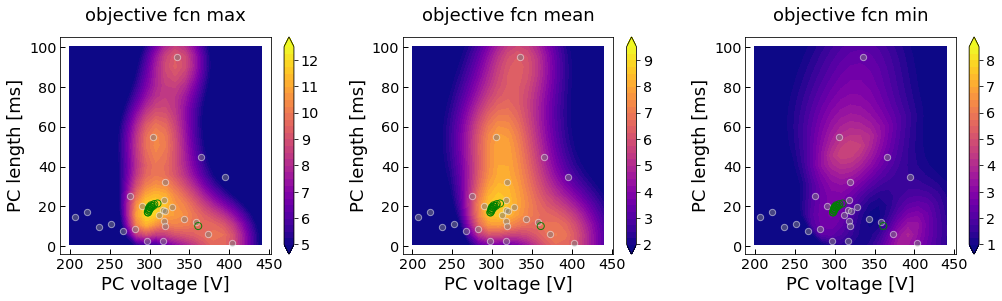

In [23]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df.iloc[:,0:4].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        
## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred, y_uncer = f_obj(x_temp)
                y_pred = -y_pred 
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])
                x1x2y_uncer.append([x1_org, x2_org, np.max(np.sqrt(y_uncer)), np.mean(np.sqrt(y_uncer)), np.min(np.sqrt(y_uncer))])
                
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        y_pred_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        y_uncer_max = np.array(x1x2y_uncer, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_uncer_mean = np.array(x1x2y_uncer, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_uncer_min = np.array(x1x2y_uncer, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
## Contour for Prediction Efficiency Mean
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [5, 2, 1]
        for ax, c_offset, y in zip(axes, colorbar_offset,
                                   [y_pred_max, y_pred_mean, y_pred_min]):#[y_pred_max, y_pred_mean, y_pred_min]
            
            c_plt1 = ax.contourf(x1, x2, y, levels = np.arange(31)*0.25+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 40, facecolors='gray', alpha = 0.5, edgecolor = 'white')

            ax.scatter(df_Xnew.values[:, ind1], 
                       df_Xnew.values[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize =  fs)

            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#MAPbI3
                ax.set_xticks([1.2, 1.3, 1.4, 1.5, 1.6])
        
            if ind1==1:#CH2I2
                ax.set_xticks([0, 50, 100, 150, 200, 250])
            if ind1==2:#PC voltage
                ax.set_xticks([200, 250, 300, 350, 400, 450])
            if ind1==3:#PC length
                ax.set_xticks([0, 25, 50, 75, 100])

        axes[0].set_title('objective fcn max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('objective fcn mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('objective fcn min', pad = title_pad,fontsize =  fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()


#### Partial Contours of Acquisition Functions

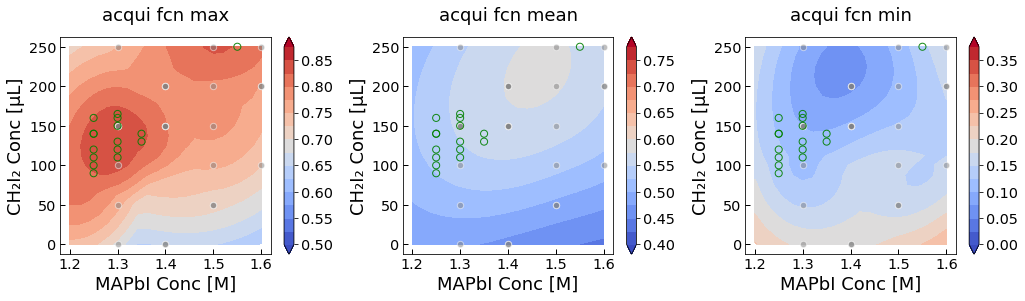

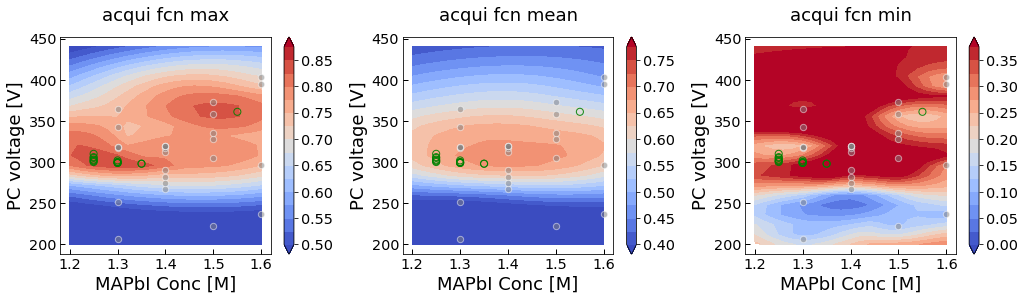

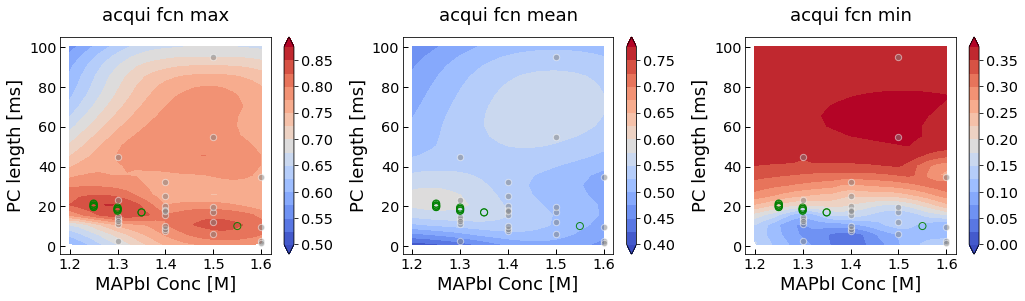

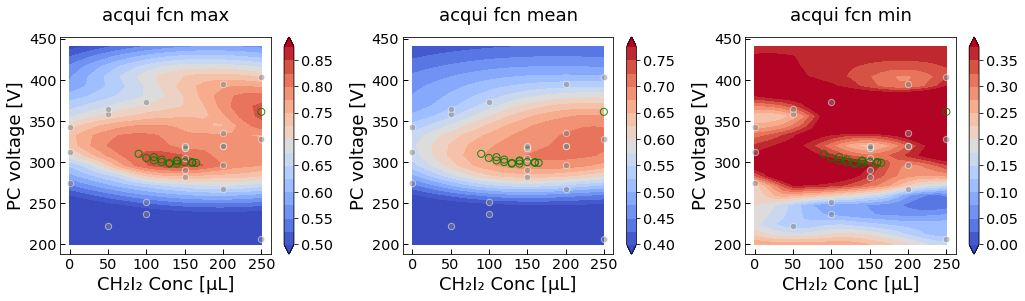

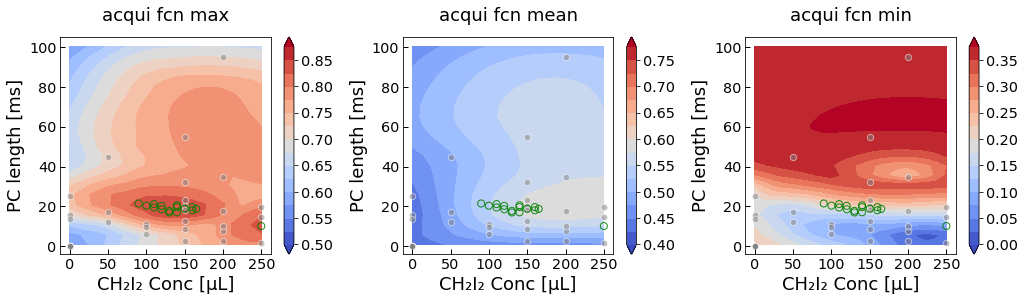

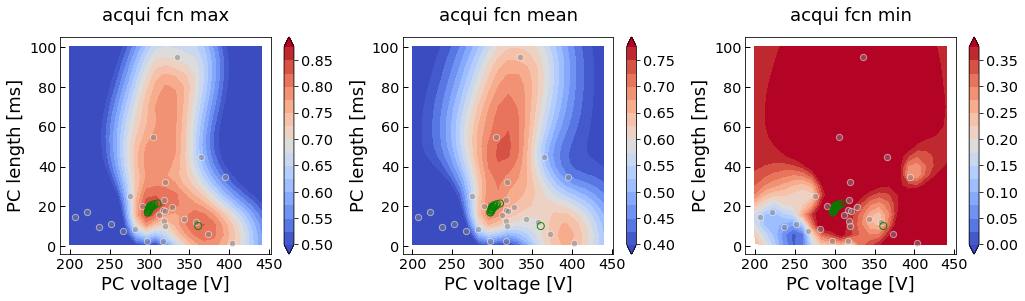

In [24]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df.iloc[:,0:4].columns
for i in range(input_dim):
    for j in range(input_dim-i-1):
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_var =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                yc_pr = f_acq(x_temp)
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(yc_pr), np.mean(yc_pr), np.min(yc_pr)])
                
        x1c = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2c = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        yc_pr_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        yc_pr_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        yc_pr_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)

        fs = 18
        title_pad = 16
        
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [0.5, 0.4, 0.0]
        norm = 16
        for ax, y, c_offset in zip(axes, [yc_pr_max, yc_pr_mean, yc_pr_min],colorbar_offset):
            c_plt1 = ax.contourf(x1c, x2c, y/norm, levels = np.arange(16)*0.025+c_offset, cmap='coolwarm', extend = 'both')# 
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
            ax.scatter(x_denormalizer(X)[:, ind1], 
                       x_denormalizer(X)[:, ind2], 
                       s = 40, facecolors='gray', alpha = 0.5, edgecolor = 'white')
            ax.scatter(df_Xnew.values[:, ind1], 
                       df_Xnew.values[:, ind2], 
                       s = 50, facecolors='none', alpha = 0.9, edgecolor = 'green')
            ax.set_xlabel(str(x_columns[ind1]),fontsize = fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize = fs)

            x1_delta = (np.max(x1c)-np.min(x1c))*0.05
            x2_delta = (np.max(x2c)-np.min(x2c))*0.05
            ax.set_xlim(np.min(x1c)-x1_delta, np.max(x1c)+x1_delta)
            ax.set_ylim(np.min(x2c)-x2_delta, np.max(x2c)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
            if ind1==0:#MAPbI3
                ax.set_xticks([1.2, 1.3, 1.4, 1.5, 1.6])
            if ind1==1:#CH2I2
                ax.set_xticks([0, 50, 100, 150, 200, 250])
            if ind1==2:#PC voltage
                ax.set_xticks([200, 250, 300, 350, 400, 450])
            if ind1==3:#PC length
                ax.set_xticks([0, 25, 50, 75, 100])
            
        axes[0].set_title('acqui fcn max', pad = title_pad,fontsize = fs)
        axes[1].set_title('acqui fcn mean', pad = title_pad,fontsize = fs)
        axes[2].set_title('acqui fcn min', pad = title_pad,fontsize = fs)
        plt.subplots_adjust(wspace = 0.3)
        plt.show()
        